In [ ]:
# for CUDA
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6
!pip install gluoncv

num_gpus = 1

ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

In [ ]:
# for CPU
!pip install mxnet==1.6.0  # updating mxnet to at least v1.6
!pip install gluoncv

ctx = [mx.cpu()]

In [1]:
import os

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import gluoncv as gcv

In [2]:
from mxnet import gluon, autograd, lr_scheduler
from mxnet.gluon import nn

from mxnet.gluon.data.vision import transforms

from gluoncv import model_zoo, utils

In [4]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
dataset_path = '../food_dataset/'

classes = ['borscht', 'lagman', 'manty', 'plov', 'samsy']

In [8]:
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

In [9]:
batch_size = 64

In [10]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=-1)

In [11]:
test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=-1)

In [12]:
len(train_data), len(test_data)

(42, 8)

In [13]:
train_dataset = gluon.data.vision.ImageFolderDataset(train_path)

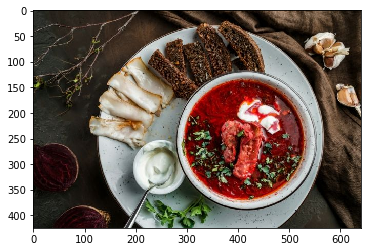

In [19]:
utils.viz.plot_image(train_dataset[420][0])

In [20]:
# Model

model_name = 'ResNet50_v2'

In [21]:
finetune_net = model_zoo.get_model(model_name, pretrained=True)

92863KB [00:27, 3338.16KB/s]                           


In [22]:
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(len(classes))

In [23]:
finetune_net

ResNetV2(
  (features): HybridSequential(
    (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
    (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (3): Activation(relu)
    (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (5): HybridSequential(
      (0): BottleneckV2(
        (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        (conv1): Conv2D(64 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm(axis=1, eps=1e-0

In [ ]:
finetune_net.initialize(mx.init.Xavier(), ctx=ctx)

In [25]:
finetune_net.collect_params().reset_ctx(ctx)

In [26]:
finetune_net.hybridize()

In [27]:
wd = 0.001
lr = 0.001

# scheduler = lr_scheduler.MultiFactorScheduler(step=5, factor=0.5, base_lr=0.1)

In [28]:
trainer = gluon.Trainer(finetune_net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})

In [29]:
metric = mx.metric.Accuracy()
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

In [30]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

In [31]:
from tqdm.notebook import tqdm # iteration load bar
import time

In [32]:
lr_decay = 0.8
lr_steps = 10
epochs = 50

In [33]:
lr_counter = 0
num_batch = len(train_data)

train_acc_outputs = []
test_acc_outputs = []
cost_outputs = []

In [ ]:
for epoch in range(epochs):
    if (epoch % lr_steps == 0 and epoch != 0):
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        print(f"Learning rate is decreased by {lr_decay}. Current lr: {trainer.learning_rate}")
        lr_counter += 1

    tic = time.time()
    cost = 0
  
    metric.reset()

    for i, batch in tqdm(enumerate(train_data)):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)

        with autograd.record():
            outputs = [finetune_net(X) for X in data]
            loss = [criterion(y_pred, y) for y_pred, y in zip(outputs, label)]
        
        for l in loss:
            l.backward()

        trainer.step(batch_size)

        cost += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)
    
    _, train_acc = metric.get()
    train_acc_outputs.append(train_acc)

    cost /= num_batch
    cost_outputs.append(cost)

    _, val_acc = test(finetune_net, test_data, ctx)
    test_acc_outputs.append(val_acc)

    print("[Epoch %d] Train-acc: %.3f, train-loss: %.3f | Test-acc: %.3f | time: %.1f" %
            (epoch, train_acc, cost, val_acc, time.time() - tic))

In [ ]:
plt.plot(list(range(epochs)), train_acc_outputs, label='train_acc', color='blue')
plt.plot(list(range(epochs)), test_acc_outputs, label='test_acc', color='orange')
plt.plot(list(range(epochs)), cost_outputs, label='cost', color='red')

In [ ]:
save_filename = f"{model_name}_epochs{epochs}-lr{lr}-wd{wd}"
save_path = os.path.join('../trained_parameters/', save_filename)

finetune_net.export(save_path)